# Chapter 4: Sampling & Fourier Transform 

### Import libraries

In [2]:
%matplotlib inline 
from PIL import Image
from skimage.io import imread, imshow, showe
import scipy.fftpack as fp
from scipy import ndimage, signal, interpolate, misc
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import data, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
from skimage.filters import window, gaussian
from scipy.linalg import hadamard
import matplotlib.pylab as plt
import numpy as np
import cv2
import timeit
import warnings
warnings.filterwarnings('ignore')

## Sampling
Sampling refers to the selection / rejection of image pixels, it is a spatial operation. We can
use sampling to increase or reduce the size of an image, with up-sampling and downsampling, respectively. In the next few sections different sampling techniques will be
described with example.

## Up-Sampling

As discussed briefly Chapter 1, Getting Started with Image Processing, in order to increase the size of an image we
need to up-sample the image. The challenge is that in the new larger image will have some
pixels corresponding to which we shall have no pixel in the original smaller image and we
need to guess those unknown pixel values. We can guess the value of an unknown pixel
using

* An aggregate, for example, the mean value of its nearest known one or more
pixel-neighbors values
* An interpolated value using pixel-neighbors with bi-linear or cubic interpolation
Nearest neighbor-based up-sampling may result in a poor quality output image. Let's code
to verify this. first let's load the input small clock image:

In [ ]:
im = Image.open("images/clock.jpg") # the original small clock image
plt.imshow(im), plt.axis('off')
plt.show()

Let's now increase the width and height of the original image to a factor of five (thereby
increasing the image size 25 times):

In [ ]:
im1 = im.resize((im.width*5, im.height*5), Image.NEAREST) # nearest neighbor interpolation
plt.figure(figsize=(10,10)), plt.imshow(im1)
plt.show()

The above figure shows the output of the nearest neighbor up-sampling, which does not work well; we
obtain a larger pixelated image. As we can see, the output image, created with the nearest-neighbor method, is 25 times
larger than the input image, using the `PIL` library's `resize()` function. But clearly the
output image is pixelated (with the blocking artifacts and jagged edges) and is of poor
quality.

## Up-Sampling and Interpolation

An image is a discrete point-sampling $f$ of a continuous function $f_F$, we can think it as a continuous function $$f_F(x,y)=\begin{cases} f(x,y) & \text{ if }  (x,y) \in \mathcal{Z}^2 \\ 0 & \text{ otherwise} \end{cases}$$  Since we don’t know the continuous function, we need to guess an approximation for it. 

Given the samples $S$ of an image $f_F$ the task of interpolation is to calculate a value for $f_F(x,y)$ even for those $(x,y)$ that are not sample points. Image interpolation tries to attain a best estimation of a pixel's intensity based on neighboring pixel values on proximity basis. 

For example, let's say we want to resize an image to double its height and widht: the simplest approach is to *repeat* each row and column 2 times in the image - this is known as the **nearest neighbor** interpolation, which often crates pixelated output image of poor quality (as shown above). In order to improve the up-sampled output image quality (e.g., *smoothness*), we can use other interpolation methods such as **bi-linear** or **bi-cubic** interpolation. Let's see how.

### Bi-linear interpolation

In [ ]:
im1 = im.resize((im.width*5, im.height*5), Image.BILINEAR) # up-sample with bi-linear interpolation
plt.figure(figsize=(10,10)), plt.imshow(im1)
plt.show()

The above figure shows the resized image. Notice how the quality improves when bi-linear interpolation is
used with up-sampling.

### Bi-cubic interpolation

It is an extension of cubic interpolation for interpolating data points on a 2D regular grid.
The interpolated surface is smoother than corresponding surfaces obtained by bi-linear
interpolation or nearest-neighbor interpolation.
Bi-cubic interpolation can be accomplished using either Lagrange polynomials, cubic
splines, or the cubic convolution algorithm. PIL uses cubic spline interpolation in a 4 x 4
environment.
Let's use the PIL resize() function for bi-cubic interpolation:

In [ ]:
im.resize((im.width*10, im.height*10), Image.BICUBIC).show() # bi-cubic interpolation
plt.figure(figsize=(10,10)), plt.imshow(im1)
plt.show()

Obeserve how the quality of the resized image improves when we use bi-cubic interpolation, from the upsampled output image shown above.

### Interpolation with scipy

Let's now use `sicpy.interpolate` module's functions to create an interpolated image from samples (constructed by random selection of pixels) from the image. The parameter `nsamples` passed to the function `create_interpolated_image()` denotes the number of random samples to be chosen from the image, using them it reconstructs the image using the function `scipy.interpolate.griddata()`, which is used to interpolate unstructured 2-D data, using the grid points `(iy, ix)` corresponding to the samples and the corresponding pixel values at those points. It uses `method='linear'` by default, which performs a **piecewise linear interpolation** (chnage it to `cubic` which will return the value determined from a cubic spline and note the result).

The next code snippet reconstructs the *Lena* image from different number of samples from the image. As can be seen from the next figure, the reconstructed image becomes close to the original one as we increase number of samples used to carry out the interpolation.

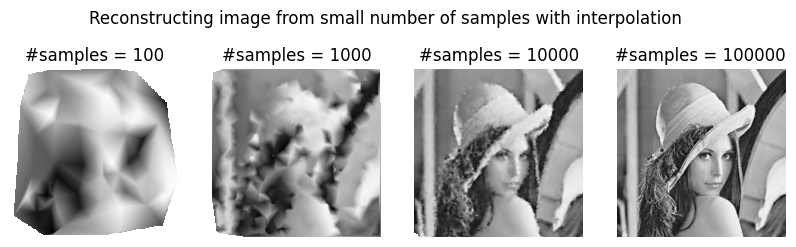

In [93]:
def create_interpolated_image(nsamples):
    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = interpolate.griddata((iy, ix), samples, (Y, X))
    return int_im

# Read in image and convert to greyscale array object
im = Image.open('images/lena.jpg')
im = np.array(im.convert('L'))

# A meshgrid of pixel coordinates
nx, ny = im.shape[1], im.shape[0]
X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))

# Create a figure of nrows x ncols subplots, and orient it appropriately
# for the aspect ratio of the image.
nrows, ncols = 1, 4
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,3), dpi=100)
if nx < ny:
    w, h = fig.get_figwidth(), fig.get_figheight()
    fig.set_figwidth(h), fig.set_figheight(w)

# Sample 100, 1,000, 10,000 and 100,000 points and plot the interpolated
# images in the figure
for i in range(4):
    nsamples = 10**(i+2)
    axes = ax[i]
    axes.imshow(create_interpolated_image(nsamples),
                          cmap=plt.get_cmap('Greys_r'))
    axes.axis('off')
    axes.set_title(f'#samples = {nsamples}')
plt.suptitle('Reconstructing image from small number of samples with linear interpolation')
plt.show()

You can use the function `scipy.interpolate.bisplrep()` for interpolation, by finding a bivariate **B-spline** representation of the image surface. How does that work?

## Inpainting with RBF Interpolation
  
![](images/rbf.png)

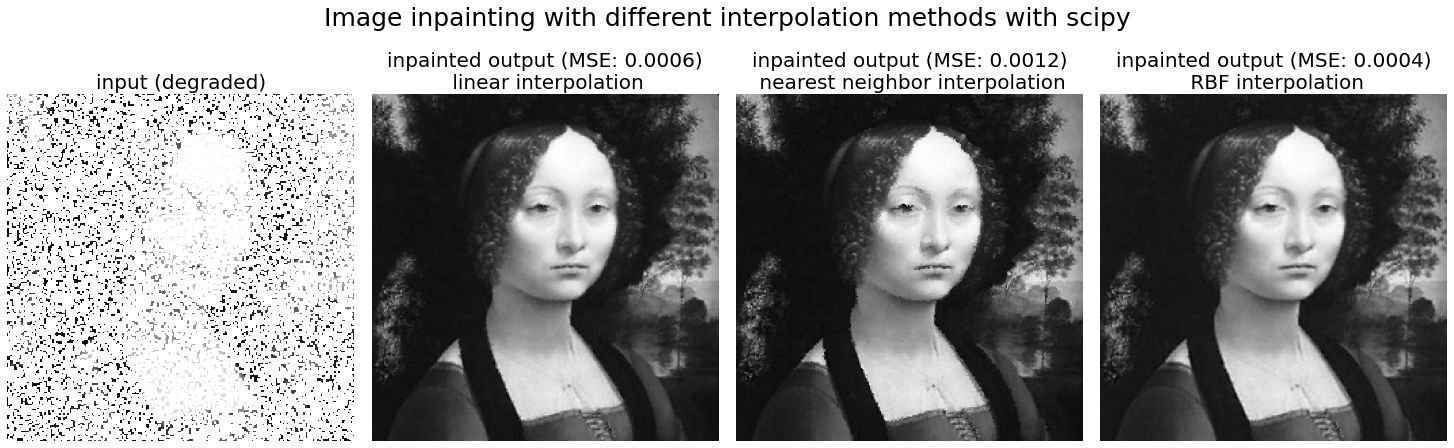

In [43]:
def get_inpainted(coords, values, im_shape, interpolator):
    return interpolator(list(np.ndindex(im_shape))).reshape(im_shape)

def get_MSE(im_orig, im_inpainted):
    return np.linalg.norm(im_orig - im_inpainted)**2 / np.prod(im_orig.shape)

im_orig = imread('images/lady.png', as_gray=True)
im = im_orig.copy()
h, w = im.shape
x, y = np.arange(h), np.arange(w)

np.random.seed(11)
# corrupt some values
mask = np.random.random(im.shape) > 0.6
im[mask] = np.nan

np.sum(mask) / np.prod(mask.shape)
# 0.40179443359375

valid_mask = ~np.isnan(im)
coords = np.array(np.nonzero(valid_mask)).T
values = im[valid_mask]

plt.figure(figsize=(20,7))
plt.subplots_adjust(0,0,1,0.925,0.05,0.05)
plt.subplot(141), plt.axis('off'), plt.imshow(im), plt.title('input (degraded)', size=20)
im_inpainted = get_inpainted(coords, values, im.shape, interpolate.LinearNDInterpolator(coords, values, fill_value=0))
plt.subplot(142), plt.axis('off')
plt.title('inpainted output (MSE: {:.4f})\n linear interpolation'.format(get_MSE(im_orig, im_inpainted)), size=20)
plt.imshow(im_inpainted)
im_inpainted = get_inpainted(coords, values, im.shape, interpolate.NearestNDInterpolator(coords, values))
plt.subplot(143), plt.axis('off')
plt.title('inpainted output (MSE: {:.4f})\n nearest neighbor interpolation'.format(get_MSE(im_orig, im_inpainted)), size=20)
plt.imshow(im_inpainted)
im_inpainted = get_inpainted(coords, values, im.shape, interpolate.RBFInterpolator(coords, values, neighbors=50))
plt.subplot(144), plt.axis('off')
plt.title('inpainted output (MSE: {:.4f})\n RBF interpolation'.format(get_MSE(im_orig, im_inpainted)), size=20)
plt.imshow(im_inpainted)
plt.suptitle('Image inpainting with different interpolation methods with scipy', size=25)
plt.show()

As can be seen from the above figure, both the RBF and linear interpolation algorithms outperform the naive nearest neighbor interpolation for image reconstruction.

### Denoising with Spline Filter

A B-spline curve is defined as a linear comibination of control (**Boor**) points $p_i$ and B-spline basis function $N_{i,k}(t)$ is given by (1-D):

![](images/bspline1.png)

Basis function is defined on **Knot vector** with  $n+k+1$ elements = number of control points ($=n+1$) + order of curve ($=k$). Each knot span $t_i \leq t \leq t_{i+1}$ is mapped onto a polynomial curve between two successive joints $r(t_i)$ and $r(t_{i+1})$. The following figure shows a B-spline curve of order $4$ given the control points and the correponding basis functions.

![](images/bspline2.png)

In the next code snippet, we shall add some salt noise (randomly select $15\%$ of the pixels in the image and make them white) to the input image and then use the `spline_filter()` function to smooth the noisy image with a B-spline filter of order $3$. Also, note that to improve the contrast of the output image the function `equalize_hist()` from `skimage.exposure` module is used (you will learn about **histogram equalization** as an image enhancement technique in later  chapters) The next figure shows that most of the noise pixels are removed (smoothed out) with the filter. Can you improve the result?

In [ ]:
from scipy.ndimage import spline_filter
from skimage.exposure import equalize_hist

im_orig = imread('images/lady.png', True)
im = im_orig.copy()
h, w = im.shape
x, y = np.arange(h), np.arange(w)

# Destroy some values
np.random.seed(11)
mask = np.random.random(im.shape) > 0.85
im[mask] = 1

sp_filter = spline_filter(im, order=3, mode='nearest')
f, ax = plt.subplots(1, 3, sharex=True, figsize=(15,7))
for ind, data in enumerate([[im_orig, "original image"],
                            [im, "noisy image (salt)"],
                            [sp_filter, "denoised (spline filter)"]]):
    ax[ind].imshow(equalize_hist(data[0]), cmap='gray')
    ax[ind].axis('off')
    ax[ind].set_title(data[1], size=20)
plt.tight_layout()
plt.show()

## Down-Sampling

In order to decrease the size of an image, we need to down-sample the image. For each
pixel in the new smaller image, there will be multiple pixels in the original larger image.
We can compute the value of a pixel in the new image by doing the following:
* Dropping some pixels (for example, dropping every other row and column if we
want an image a fourth of the size of the original image) from the larger image in
a systematic way
* Computing the new pixel value as an aggregate value of the corresponding
multiple pixels in the original image

### The Sampling Theorem (Shannon-Nyquist Theorem)

If the Fourier transform of a continuous function $ƒ(x,y)$ is band-limited (i.e., zero for all frequencies beyond $u_{max}$ and $v_{max}$), then the function can be completely reconstructed from its samples when the signal is measured at least **twice per periods**, i.e., as long as the sampling distances $\Delta x$ and $\Delta y$ along the $x$ and $y$ directions are such that $\Delta x \leq \frac{1}{2u_{max}}$ and $\Delta y \leq \frac{1}{2v_{max}}$. 

Put it in another way, the Shannon's Sampling Theorem states that the minimum sampling frequency (known as **Nyquist rate**) should be such that $f_s ≥ 2f_{max}$, where $f_{max}$ is the maximum frequency. If the original image has frequencies that are high, then it means that sampling rate needs to be high too (at least twice the maximum frequency) for proper reconstruction. 

Let's use an image of a shirt (of size $419 \times 600$) with narrow stripes on it (corresponding to high frequecny components) and crop a $70 \times 70$ square region (with sides colored red in the following figure) from the image and downsample it to understand how artifacts become more prominent as the output image size get reduced more and more.

In [ ]:
import PIL
print(PIL.__version__)
im = Image.open("images/shirt.jpg")
crop_coords = (0, 200, 70, 270)
plt.figure(figsize=(10,5), constrained_layout=True)
plt.subplot(121)
plt.imshow(cv2.rectangle(np.array(im).copy(), crop_coords[:2], crop_coords[-2:], (255,0,0), 2), aspect='auto') 
plt.axis('off'), plt.title(f'original image ({im.height} x {im.width})', size=20) 
plt.subplot(122)
plt.imshow(np.array(im)[crop_coords[1]:crop_coords[3], crop_coords[0]:crop_coords[2]], aspect='auto')
plt.axis('off')
plt.title(f'portion to be resized ({crop_coords[2]-crop_coords[0]}x{crop_coords[3]-crop_coords[1]})', size=20) 
plt.show()

### Convolution-based Resizing (resampling) with PIL

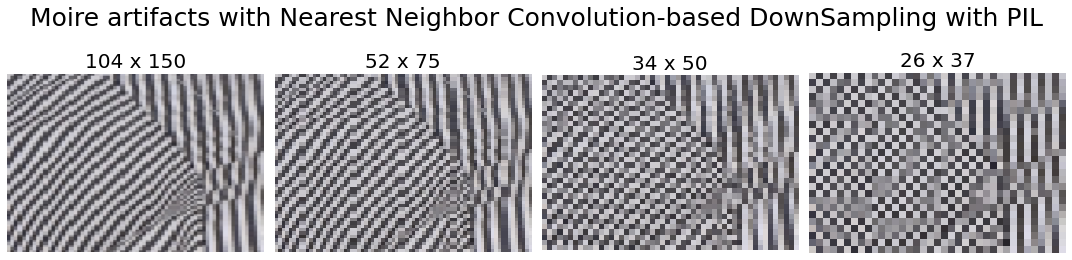

In [465]:
plt.figure(figsize=(15,4))
i = 1
for factor in range(4,20,4):
    im_rsz = im.resize((int(im.width/factor), int(im.height/factor)), resample=Image.NEAREST, box=crop_coords)
    plt.subplot(1,4,i), plt.imshow(im_rsz), plt.axis('off'), plt.title(f'{im_rsz.height} x {im_rsz.width}', size=20)
    i += 1
plt.suptitle('Moire artifacts with Nearest Neighbor Convolution-based DownSampling with PIL', size=25)
plt.tight_layout()
plt.show()

Now, let' use the original image again and downsample it 6 times it original size using the convolution-based resizing again (using the same `resize()` function), but using two different resampling methods (specified by the parameter `resample=Image.NEAREST` and `resample=Image.LANCZOS`, respectively), first using the nearest neighborand next using the *Lanczos* method.
* The NN mehtod calculates the output pixel value by picking one nearest pixel from the input image and it ignores all other input pixels. 
* The Lanczos method calculates the output pixel value using a high-quality **Lanczos** filter - a truncated **sinc** on all pixels that may contribute to the output value.

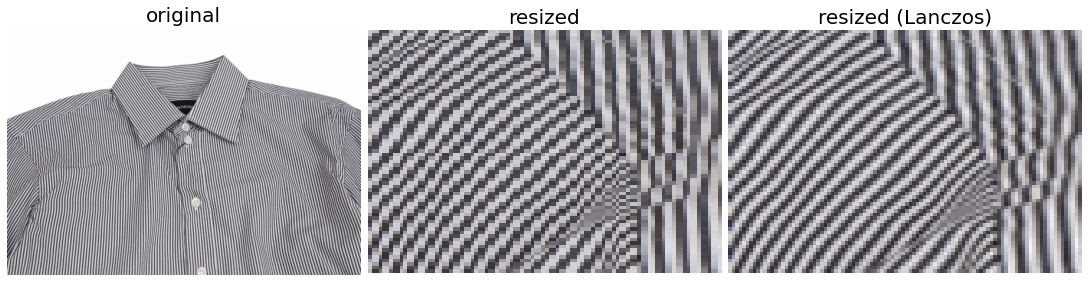

In [466]:
factor = 6
crop_coords = (0, 200, 70, 270)
im_rsz = im.resize((int(im.width/factor), int(im.height/factor)), resample=Image.NEAREST, box=crop_coords)
im_rsz_antialiased = im.resize((int(im.width/factor), int(im.height/factor)), resample=Image.LANCZOS, box=crop_coords)

plt.figure(figsize=(15,7), constrained_layout=True)
plt.subplot(131), plt.imshow(im), plt.axis('off'), plt.title('original', size=20) 
plt.subplot(132), plt.imshow(im_rsz), plt.axis('off'), plt.title('resized', size=20) 
plt.subplot(133), plt.imshow(im_rsz_antialiased) #, interpolation='antialiased')
plt.axis('off'), plt.title('resized (Lanczos)', size=20) 
plt.show()

As can be seen from the output above, the **Lanczos** resampling method almost got rid of the artifact, whereas the nearst neighbor intorduced Moire artifacts. 

## Down-sampling and anti-aliasing

As we have seen, down-sampling is not very good for shrinking images as it creates an
**aliasing** effect, when the signal has frequencies above the **Nyquist** limit. For instance, if we try to resize (down-sample) the original image by reducing the width and height a factor of 6, we shall get such patchy and bad output.

### Anti-aliasing

To reduce aliasing, one can do either of the following:
* Increase sampling frequency
* Reduce maximum frequency to below Nyquist limit (e.g. low pass filter before sampling).

The problem here is that a single pixel in the output image corresponds to 36 pixels in the
input image, but we are sampling the value of a single pixel instead. We should be
averaging over a small area in the input image. This can be done using **anti-aliasing**, to obtain a high quality
down-sampling filter. Anti-aliasing is generally done by smoothing an image (via convolution of the image with
a low-pass filter such as a Gaussian filter) before down-sampling (to remove high frequencies that cause aliasing).

### Rescaling with scikit-image

Let's now use the `scikit-image` `transform` module's `rescale()` function to rescale an image $0.3$ times the original image repeatedly, with and withoout `antialiasing`, and compare the results, to observe which one overcome the aliasing problem, using another input image, namely the image of *UMBC*.

In [ ]:
im = imread('images/umbc.png')
print(im.shape)
im1 = im.copy()
plt.figure(figsize=(16,11))
for i in range(2):
    im1 = rescale(im1, scale = 0.3, multichannel=True, anti_aliasing=False)
    plt.subplot(2,2,i+1), plt.imshow(im1, cmap='gray'), plt.axis('off')
    plt.title(f'image size = {im1.shape[1]} x {im1.shape[0]} antialiasing=False', size=20)
im1 = im.copy()
for i in range(2):
    im1 = rescale(im1, scale = 0.3, multichannel=True, anti_aliasing=True)
    plt.subplot(2,2,i+3), plt.imshow(im1, cmap='gray'), plt.axis('off')
    plt.title(f'image size = {im1.shape[1]} x {im1.shape[0]} antialiasing=True', size=20)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

As can be seen in the above output, the image is down-sampled to create smaller and smaller output—the aliasing effect becomes more prominent when no anti-aliasing is used (`anti_aliasing=False`). But with `anti_aliasing=True` it yields  images of better quality.

To learn more about interpolation and anti-aliasing, please visit my blog: https://sandipanweb.wordpress.com/2018/01/21/recursivegraphics-bilinear-interpolation-and-image-transformation-in-Python/.

## Quantization

Quantization is related to the intensity of an image and can be defined by the number of
bits used per pixel. Digital images typically are quantized to 256 gray levels. Here, we will
see that, as the number of bits for pixel storage decreases, the quantization error increases,
leading to artificial boundaries or contours and pixelating and resulting in the poor quality
of an image.

### Quantizing with PIL

Let's use the `convert()` method from `PIL`'s `Image` class for color quantization, with the
`P` mode and the color argument as the maximum number of possible colors, and the `quantize()` method for the same purpose.  We'll also use the `scikit-image.metrics` module's `peak_signal_noise_ratio` function to find the Signal-to-Noise Ratio
(**SNR**) of an image (of a *parrot*), which is defined as the mean divided by the standard deviation of the image array, as shown below. We shall also save the quantized images and measure their disk storage sizes (in KB) using `os.path.getsize()` function.

In [ ]:
im = Image.open('images/parrot.png')
plt.figure(figsize=(15,25))
num_colors_list = [1 << n for n in range(8,0,-1)]
im = im.convert('P', palette=Image.ADAPTIVE, colors=num_colors_list[0])
snr_list = []
size_KB_list = []
i = 1
for num_colors in num_colors_list[1:]:
    im1 = im.quantize(colors=num_colors)
    plt.subplot(4,2,i), plt.imshow(im1), plt.axis('off')
    snr_list.append(psnr(np.array(im), np.array(im1)))
    im1.save(f'images/parrot_{num_colors}.png')    
    size_KB_list.append(os.path.getsize(f'images/parrot_{num_colors}.png')/2**10)
    plt.title(f'Image with # colors = {num_colors} SNR = {np.round(snr_list[i-1],3)}', size=20)
    i += 1
plt.subplots_adjust(0,0,1,0.94,0.05,0.05)
plt.show()

We'll now plot the impact of color-quantization on the SNR of the image, which is typically
a measure for image quality—the higher the SNR, the better the quality. We shall also plot the reduced image storage size on disk (compression achieved due to quantization).

In [ ]:
def plot_line(x, y, xlab, ylab, title):
    plt.plot(x, y, 'r.-')
    plt.xlabel(xlab, size=15)
    plt.ylabel(ylab, size=15)
    plt.title(title, size=20)
    plt.xscale('log', base=2)
    plt.gca().invert_xaxis()
    plt.grid()
    
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_line(num_colors_list[1:], snr_list, '# colors in the image', 'SNR', 'Change in SNR w.r.t. # colors')
plt.subplot(122)
plot_line(num_colors_list[1:], size_KB_list, '# colors in the image', 'size in KB', 'Change in image size (KB) w.r.t. # colors')
plt.tight_layout()
plt.show()

As can be seen from the above plot, although the color-quantization reduces image's disk storage size (since the number
of bits/pixel gets reduced), it also makes the quality of the image poorer, measured by the SNR.

## Discrete Fourier Transform

### The Fast Fourier Transform algorithm to compute the DFT

The Fast Fourier Transform (**FFT**) is a divide and conquer algorithm to recursively compute the DFT much quicker (with O ($N^2.log_2N$) time complexity) than the much slower $O(N^4)$ naive computation for an $N \times N$ image. In Python,
both the `numpy` and `scipy` libraries provide functions to compute 2D DFT/IDFT using the FFT algorithm. Let's see a few examples.

### FFT with the scipy.fftpack module

We'll use the `scipy.fftpack` module's `fft2()/ifft2()` function to compute the DFT/IDFT with the FFT algorithm using a the following grayscale image of the rhinos.

In [ ]:
im = np.array(Image.open('images/rhino.jpg').convert('L')) # we shall work with grayscale image
im = im / im.max()
# call FFT and IFFT
freq = fp.fft2(im)
im_rec = fp.ifft2(freq).real
im_rec = im_rec / im_rec.max()
print('Error in reconstruction = {}'.format(np.linalg.norm(im - im_rec)))
# SNR for the image obtained after reconstruction = 2.0237227738013224
assert(np.allclose(im, im_rec)) # make sure the forward and inverse FFT are close to each other
plt.figure(figsize=(15,10))
plt.subplot(121), plt.imshow(im, cmap='gray'), plt.axis('off')
plt.title('Original Image', size=20)
plt.subplot(122), plt.imshow(im_rec, cmap='gray'), plt.axis('off')
plt.title('Image obtained after reconstruction', size=20)
plt.tight_layout()
plt.show()

As can be seen from the error in reconstruction and from the visual difference
in the input and the reconstructed image, the reconstructed image loses some information.
The difference is negligible since we used all of the coefficients obtained for reconstruction.

### Plotting the frequency spectrum

As Fourier coefficients are complex numbers, we can view magnitudes directly. Displaying
magnitudes of Fourier transforms is called the spectrum of the transform. The value $F(0,0)$ of the DFT is called the **DC coefficient**. The DC coefficient is too large for the other coefficient values to be seen, which is why we need to stretch the transform values by displaying the logarithm of the transform.  A useful processing technique which compensates for
this difficulty consists of displaying one of the functions like the following ones, instead of direct display of $|F(u,v)|$:

* $D_1(u,v) = log(1 + |F( u, v)|)$
* $D_2(u,v) = min(255, |F(u,v)| + 100)$

Also, $F(0,0)$ is at top left corner,  for display, it is convenient to have DC component in center, hence need to swap four quadrants of DFT before displaying. The transform coefficients are neeed to be shifted (with `fftshift()`) so that the
DC component is in the center (this is due to the periodicity and conjugate symmetry property of DFT, for which the low frequencies are positioned at the four corners and the high frequency at the center of the unshifted spectrum - but we want the low frequency at the center). 

The following code snippet implements a function `plot_spectrum` which will enable us to plot the spectrum in two different ways (like the ones shown above), the parameter `method='log` will display the `log`-transform-based visualization, otherwise it default to the second transform ($D_2$). Excited to create a Fourier spectrum of the rhino image? Code this:

In [ ]:
def plot_spectrum(F, method=None, cmap='coolwarm'):
    F_disp = (20*np.log10(0.01 + np.abs(F))).astype(int) if method == 'log' else np.minimum(np.abs(F).astype(int)+100, 255) 
    plt.imshow(F_disp, cmap=cmap, aspect='auto')

# the quadrants are needed to be shifted around in order that the low spatial frequencies are in the center of the 2D fourier-transformed image.
freq2 = fp.fftshift(freq)
plt.figure(figsize=(15,4))
plt.subplot(131), plot_spectrum(freq, cmap='inferno'), plt.title('not shifted', size=15)
plt.subplot(132), plot_spectrum(freq2, cmap='inferno'), plt.title(r'shifted ($D_1$)', size=15)
plt.subplot(133), plot_spectrum(freq2, method='log', cmap='inferno'), plt.title(r'shifted ($D_2$)', size=15)
plt.suptitle('Plotting the (shifted) DFT Spectrum of the rhinos image', size=20)
plt.tight_layout()
plt.show()

Are you surprised? The above figure shows what the rhino image looks like, in its Fourier spectrum form. 

Let's compute the DFTs of the following simple images and try to explain the DFT patterns (e.g., think of how many frequencies are needed to represent the image in spatial domain, e.g., large horizontal frequencies correspond
to vertical lines in the image). 

![](images/dfts.png)

You can even prove the results mathematically with the definition of the continuous Fourier transform, the functions and using the separability theorem, as shown in the next figure. 

![](images/cft.png)

For example, you can show that the Fourier Transform of a rectangle centered at origin will be a product of two **sinc** functions: more precisely, $F(u,v) = XY sinc(\pi Xu) sinc(\pi Yv)$ for a $X\times Y$ rectangle centered at origin, where $sinc(\theta)=\frac{sin(\theta)}{\theta}$, using the following steps:
   * start from the definition of a 1-D rectangle function
   * show that FT of 1-D rectangle function is 1-D sinc function using the intergral
   * use the fact that 2D rectangle function is separable and can be written as product of two 1-D rectangle functions
   * use the **separability theorem** to compute 2-D FT from the 1-D FTs.
   
For the square in the above figure, you will obtain product of two *sinc* functions with DFT, plot it in 3-D to obtain a figure like the following one:

![](images/sinc.png)

### FFT with the numpy.fft module

The DFT of an image can be computed with the `numpy.fft` module's similar set of
functions. We'll see some examples.
Computing the magnitude and phase of a DFT
We'll use the house.png image as input and thus `fft2()` to get the real and imaginary
components of the Fourier coefficients; after that, we'll compute the
magnitude/spectrum and the phase and, finally, use `ifft2()` to reconstruct the image:

In [ ]:
im1 = rgb2gray(imread('images/house.png'))
plt.figure(figsize=(12,9))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
freq1 = np.fft.fft2(im1)
im1_hat = np.fft.ifft2(freq1).real
plt.subplot(2,2,1), plt.imshow(im1, cmap='gray'), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(2,2,2), plt.imshow(20*np.log10( 0.01 + np.abs(np.fft.fftshift(freq1))), cmap='hot')
plt.title('DFT Spectrum Maginitude', size=20)
plt.subplot(2,2,3), plt.imshow(np.angle(np.fft.fftshift(freq1)),cmap='inferno')
plt.title('DFT Spectrum Phase', size=20)
plt.subplot(2,2,4), plt.imshow(np.clip(im1_hat,0,255), cmap='gray'), plt.axis('off')
plt.title('Reconstructed Image', size=20)
plt.show()

As can be seen from the above figure, the DFT spectrum magnitude $|F(u,v)|$ generally decreases with higher spatial frequencies and the phase $\Phi(u,v)$ appears to be less informative. You can reconstruct the image directly from the magnitude and phase of the spectrum too, since $I = |F|.e^{i\Phi}$, i.e., implement `ifft2()` yourself.

Although the phase image above appears to be quite random, it contains very important information of the image. Let's now demonstrate how important phase is in DFT for image reconstruction from frequency back to spatial domain. Let's compute the spectrum/magnitude, phase, and reconstructed image with another input image.

In [ ]:
im2 = rgb2gray(imread('images/house2.png'))
assert im1.shape == im2.shape # both images must have the same shape
plt.figure(figsize=(12,9))
freq2 = np.fft.fft2(im2)
im2_hat = np.fft.ifft2(freq2).real
plt.subplot(2,2,1), plt.imshow(im2, cmap='gray'), plt.title('Original Image', size=20), plt.axis('off')
plt.subplot(2,2,2), plt.imshow(20*np.log10( 0.01 + np.abs(np.fft.fftshift(freq2))), cmap='hot')
plt.title('DFT Spectrum Maginitude', size=20)
plt.subplot(2,2,3), plt.imshow(np.angle(np.fft.fftshift(freq2)), cmap='hot')
plt.title('DFT Spectrum Phase', size=20)
plt.subplot(2,2,4), plt.imshow(np.clip(im2_hat,0,255), cmap='gray'), plt.axis('off')
plt.title('Reconstructed Image', size=20)
plt.tight_layout()
plt.show()

Now, let's generate couple of random phase images of same dimension as the above images, using the library `PyAFBF` (you need to install the specific version first with `pip`, as shown in the next code block). We shall use the implementation for simulation of a Fractional Brownian Field (`tbfield`) to generate a random texture of the given input shape.

In [ ]:
# pip install PyAFBF==0.1.7
# !pip install imgaug==0.2.6
from afbf import tbfield

N = 256  # Image size.
H = 0.2  # Hurst index in (0, 1).

# Define the field.
Z = tbfield('fbf')

# Change the parameter of the Hurst function.
Z.hurst.ChangeParameters(np.array([[H]]))
Z.NormalizeModel()

# Simulate the field.
z = Z.Simulate()
random_phase = z.values.reshape(512, 512)
plt.imshow(random_phase, cmap='gray'), plt.axis('off')
plt.title('randomly generated texture\n(Fractional Brownian field)', size=20)
plt.show()

Although it's not as informative as the magnitude, the DFT phase is also important information and an image can't be reconstructed properly if the phase is not available or if we use a different phase array, as described earlier.

To witness this, let's see how a reconstructed output image gets distorted if we use the the frequency spectrum magnitude from one image and phase from the another one for reconstruction, also what if we use random phase instead, using the next code snippet. As expected, the spatial domain reconstructions are far from the original images.

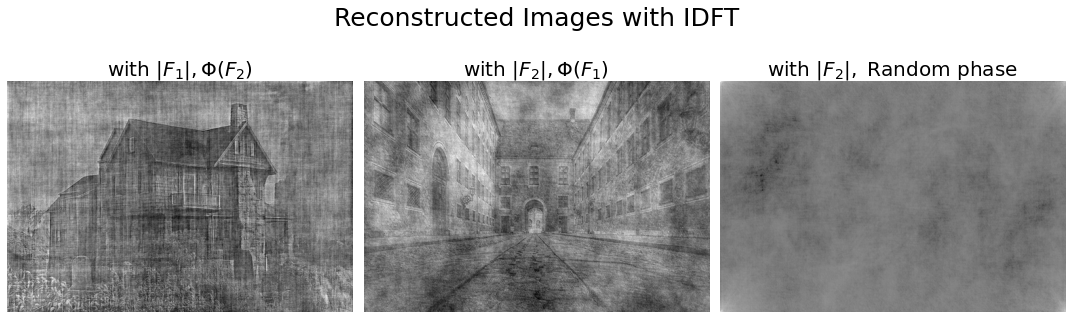

In [52]:
im1_hat = np.fft.ifft2(np.abs(freq1)*np.exp(1J*np.angle(freq2))).real
im2_hat = np.fft.ifft2(np.abs(freq2)*np.exp(1J*np.angle(freq1))).real
im2_hat_rand = np.log(np.fft.ifft2(np.abs(freq2)*np.exp(1J*resize(random_phase, im2.shape))).real) # log transform to visualize properly
plt.figure(figsize=(15,5))
plt.gray()
plt.subplot(131), plt.imshow(im1_hat), plt.axis('off')
plt.title(r'with $|F_1|, \Phi(F_2)$', size=20)
plt.subplot(132), plt.imshow(im2_hat), plt.axis('off')
plt.title(r'with $|F_2|, \Phi(F_1)$', size=20)
plt.subplot(133), plt.imshow(im2_hat_rand), plt.axis('off')
plt.title(r'with $|F_2|, $ Random phase', size=20)
plt.suptitle('Reconstructed Images with IDFT', size=25)
plt.tight_layout()
plt.show()

Also, consider reconstruction of the image only from the magnitude (with zero phase) and then only from the phase (with constant magnitude). You should obtain an output as shown in the following figure, demonstrating that both magnitude and phase images are important for reconstruction.

In [ ]:
import timeit
import pandas as pd
import seaborn as sns
import scipy
print(scipy.__version__)
import matplotlib.pylab as plt

SETUP = 'from skimage.io import imread; import numpy as np; import scipy as sp'
np_fft = timeit.repeat(setup=SETUP, 
              stmt='im = imread("images/cameraman.jpg"); f = np.fft.fft2(im)', repeat=10, number=10)
sp_fftpack_fft = timeit.repeat(setup=SETUP, 
              stmt='im = imread("images/cameraman.jpg"); f = sp.fftpack.fft2(im)', repeat=10, number=10)
sp_fft = timeit.repeat(setup=SETUP, 
              stmt='im = imread("images/cameraman.jpg"); f = sp.fft.fft2(im)', repeat=10, number=10)
fft2_time_df = pd.DataFrame({'np_fft': np_fft, 'sp_fftpack_fft': sp_fftpack_fft, 'sp_fft': sp_fft})
sns.violinplot(data=fft2_time_df)
plt.show()

### DFT with Matrix Multiplication

In [ ]:
def DFT_matrix(N, norm=None, inverse=False):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    ω = np.exp((-1)**(~inverse) * 1J * 2 * np.pi / N)
    Z = np.sqrt(N) if norm == 'sqrt' else (N if inverse else 1)
    W = np.power(ω, i * j) / Z
    return W

X = imread('images/saturn.png', True) 
X = X / X.max()
print(X.shape)

F_ref = np.fft.fft2(X) 

assert X.shape[0] == X.shape[1] # assumption: X is a square image, i.e., M=N
N = X.shape[0]
print(N)
            
W, W_I = DFT_matrix(N), DFT_matrix(N, inverse=True)
F = W @ X @ W
print(np.linalg.norm(F_ref - F))
X_hat = W_I @ F @ W_I
print(np.linalg.norm(X_hat - np.fft.ifft2(F_ref)))

plt.figure(figsize=(20,7))
plt.gray()
plt.subplots_adjust(0,0,1,0.875,0.05,0.05)
plt.subplot(141), plt.imshow(X, aspect='auto'), plt.axis('off'), plt.title('original input', size=20)
plt.subplot(142), plot_spectrum(np.fft.fftshift(F)), plt.title('spectrum', size=20)
plt.subplot(143), plot_spectrum(np.fft.fftshift(F_ref)), plt.title('spectrum (np fft)', size=20)
plt.subplot(144), plt.imshow(X_hat.real, aspect='auto'), plt.axis('off'), plt.title('reconstructed input', size=20)
plt.suptitle('Image reconstruction with DFT (with matrix multiplication)', size=25)
plt.show()

As can be seen from the above output, `numpy`'s implementation' is very close with the right normalization factor (i.e., $\frac{1}{N}$ for IDFT and $1$ for DFT) chosen. 

Also, obeserve that the matrix $W$ is symmetric and is unitary when `sqrt` normalization is chosen, i.e., $WW^{\dagger}=I$, where $W^{\dagger}$ represents the **Hermitian adjoint** of $W$ and $I$ is the corresponding identity matrix, as shown below (i.e., the basis vectors from $W$ are **orthonormal**).

In [113]:
W = DFT_matrix(N, norm='sqrt')
print(np.allclose(W, W.T))
np.allclose(np.real(W@np.conjugate(W).T), np.eye(N)), np.allclose(np.imag(W@np.conjugate(W).T), np.zeros(N))

True


(True, True)

## Discrete Cosine and Walsh-Hadamard Transform

Let's use the above concept in matrix-based computation of couple of other popular image transforms, namely, cosine and walsh-hadamard transforms. 

### Discrete Cosine Transform (DCT)

In [ ]:
f = imread('images/lena.jpg', True)
#f = imread('images/saturn.png', True) # assumtion: the image is square NxN
D = fp.dct(np.eye(f.shape[0]), norm='ortho', axis=0) #dctmtx(im.shape[0])
C = D@f@D.T
f_c = D.T@C@D

plt.figure(figsize=(15,5))
plt.gray()
plt.subplots_adjust(0,0,1,0.85,0.05,0.05)
plt.subplot(141), plt.imshow(f, aspect='auto'), plt.axis('off'), plt.title(r'input image $f$', size=20)
plt.subplot(142), plt.imshow(D, aspect='auto'), plt.axis('off'), plt.title(r'DCT matrix $D$', size=20)
plt.subplot(143), plt.imshow(20*np.log(0.001 + C.astype(int)), cmap='hot', aspect='auto'), plt.axis('off')
plt.title(r'DCT spectrum $C=DfD^T$', size=20)
plt.subplot(144), plt.imshow(f_c, aspect='auto'), plt.axis('off')
plt.title(r'recnstructed $\hat{f}=D^TCD$', size=20)
plt.suptitle('Image Reconstruction with DCT', size=22)
plt.show()

### Walsh-Hadamard Transform (WHT)

The Hadamard matrices are recursively defined as shown in the following figure:

![](images/hadamard.png)

We can obtain the **Hadamard** martix $H$ ($G=H$ here)  with the function `hadamard()` from `scipy.linalg` module. Let's see how a $8\times 8$ Hadamard matrix looks like.

In [121]:
H = hadamard(8)
print(H)

[[ 1  1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [ 1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1]
 [ 1  1  1  1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1 -1 -1  1  1]
 [ 1 -1 -1  1 -1  1  1 -1]]


Notice the columns of the above matrix, the first column has $0$ sign change, the second column has $7$ sign changes, whereas the thrid column has $3$ sign changes. Let's order the columns in such a way that they are sorted in increasing order of number of sign changes (this is called *seuqency ordering*). The function `get_sequency_ordering()` implements exactly what we want and given the above matrix $H$ as input, it will return modified *Hadamard* matrix (which is also known as **Walsh-Hadamard** matrix), by sorting it into sequency order. 

In [122]:
def get_gray_codes(nbits):
    gray_code = []
    li = [0 for i in range(nbits)]
    gray_code.append(''.join(map(str,li)))

    for term in range(2, (1<<nbits)+1):
        if term % 2:                
            for i in range(-1,-(nbits),-1):
                if li[i]==1:                        
                    li[i-1]=li[i-1]^1                        
                    break
        if term % 2 == 0:
            li[-1]=li[-1]^1
        gray_code.append(''.join(map(str,li)))
    return gray_code

def get_sequency_ordering(H):
    length = len(H)
    bitlength = int(np.log2(length))
    # Gray Code
    gray_codes = get_gray_codes(bitlength)
    # Bitreverse of gray code
    bitreverse = [int(gray_codes[i][::-1],2) for i in range(length)]
    W = H.copy()
    W = H[:,bitreverse]
    return W

print(get_sequency_ordering(H))

[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1 -1 -1 -1 -1]
 [ 1  1 -1 -1 -1 -1  1  1]
 [ 1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1]
 [ 1 -1 -1  1 -1  1  1 -1]
 [ 1 -1  1 -1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]]


Now, we are all set for applying the Walsh-Hadamard transform on the *Lena* image. For the sake of completeness, the following figure shows the forward and inverse tranformation:
    
![](images/hadamard_def.png)

Let's obtain the Hadamard matrix $H$ of the same shape as the input image, sort it by sequency ordering to obtain the matrix $W$, then apply the transform to obtain the spectrum $F=WfW^T$ and reconstruct the image from the spectrum with $\hat{f}=W^TFW$. Plot all the images to obtain a figure like the following one.

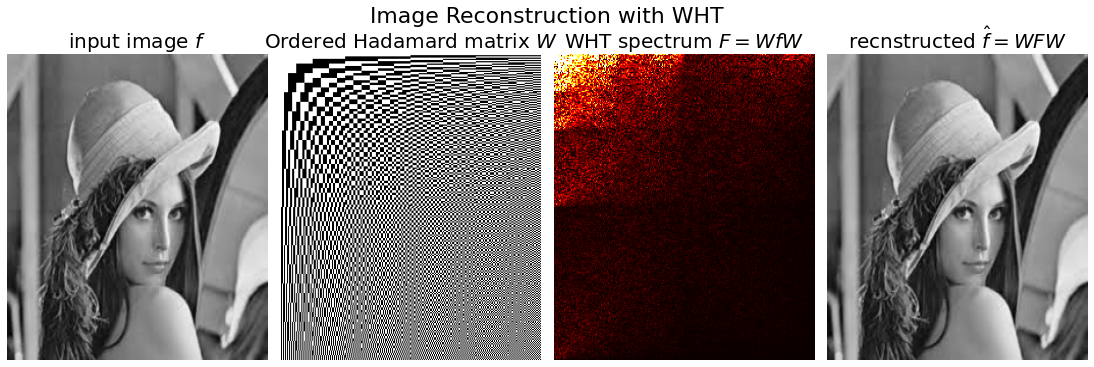

In [115]:
f = imread('images/lena.jpg', True)
f = resize(f, (256,256))
H = hadamard(f.shape[0])
W  = get_sequency_ordering(H)
F = W@f@W.T
f_w = W.T@F@W
plt.figure(figsize=(15,5))
plt.gray()
plt.subplots_adjust(0,0,1,0.85,0.05,0.05)
plt.subplot(141), plt.imshow(f, aspect='auto'), plt.axis('off'), plt.title(r'input image $f$', size=20)
plt.subplot(142), plt.imshow(W, aspect='auto'), plt.axis('off'), plt.title(r'Ordered Hadamard matrix $W$', size=20)
plt.subplot(143), plot_spectrum(F, cmap='hot'), plt.axis('off')
plt.title(r'WHT spectrum $F=WfW$', size=20)
plt.subplot(144), plt.imshow(f_w, aspect='auto'), plt.axis('off')
plt.title(r'recnstructed $\hat{f}=WFW$', size=20)
plt.suptitle('Image Reconstruction with WHT', size=22)
plt.show()

Plot the DFT, DCT and DWHT transform outputs in 3-D with `matlplotlib` (use the function `plot_surface()`), you should obtain a figure like the following one. Observe that for DCT only a few coefficients near (0,0) are non-zero, indicating that it will achieve much higher compression than other transforms.

![](images/spectrum.png)

### Basis images for DCT and Walsh Transforms

Let's now generalize all the transforms we learnt previously, namely, DFT, DCT, Walsh and Hadamard transforms. The following figure shows the transforms and how to compute them in a generalized form.

![](images/transforms.png)

In [105]:
def dct(x, y, u, v, N):
    # Normalization
    def alpha(a):
        return np.sqrt(1/N) if a==0 else np.sqrt(2/N)
    return alpha(u) * alpha(v) * np.cos(((2*x+1)*(u*np.pi))/(2*N)) * np.cos(((2*y+1)*(v*np.pi))/(2*N))

def b(i, x):
    return (x >> i) & 1

def walsh(x, y, u, v, N):    
    n = int(np.log2(N))
    return (-1)**np.sum([(b(i,x)*b(n-1-i,u)+b(i,y)*b(n-1-i,v)) for i in range(n)]) / N

def get_basis_image(u, v, g, N):
    basis_image = np.zeros((N,N))
    for x in range(N):
        for y in range(N):
            basis_image[x,y] = g(x, y, u, v, N)
    return basis_image

def get_all_basis_images(g, tname, N):
    print(f"Generating {tname} basis images")
    images = []
    for u in range(N):
        for v in range(N):
            images.append(get_basis_image(u, v, g, N))
    return images

def plot_basis_images(images, tname, N):
    plt.figure(figsize=(5,5))
    plt.gray()
    plt.subplots_adjust(0,0,1,0.925,0.05,0.05)
    for i in range(N*N):
        plt.subplot(N,N,i+1), plt.imshow(images[i].reshape(N,N)), plt.xticks([]), plt.yticks([])
    plt.suptitle(f'{N}x{N} {tname} basis functions', size=15)
    plt.show()    

#N = 4
#g, tname = dct, 'DCT'
#plot_basis_images(get_all_basis_images(g, tname, N), tname, N)      
#g, tname = walsh, 'Walsh'
#plot_basis_images(get_all_basis_images(g, tname, N), tname, N)      

![](images/dw_basis_functions.png)

## Properties of DFT

### 1. Separability

In [ ]:
def fft2_sep(f):
    return np.fft.fft(np.fft.fft(f).T).T

np.random.seed(1)
f = imread('images/lena.jpg', True)
%timeit F_sep = fft2_sep(f)
%timeit F = np.fft.fft2(f)
print(np.linalg.norm(F_sep - F))
plot_spectrum(np.hstack((np.fft.fftshift(F_sep), np.fft.fftshift(F))))

### 2. Periodicity and Windowing

The DFT has an implicit periodicity in both the spatial and the frequency domains. For a $NxN$ 2D signal, the DFT and its inverse are periodic with Period $N$:
   $$F(u,v) = F(u+N,v) = F(u,v+N) = F(u+N,v+N)$$
   
The Fourier transform also exhibits conjugate symmetry since $F(u,v) = F^*(-u, -v)$ or more interestingly,
$|F(u,v)| =|F(-u,-v)|$.

Let's understand the property with an example. Let's use the following input of a set of books in a shelf (cropped), compute the DFT and visualize the spectrum (both unshifted and shifted versions). What you may expect in the spectrum is a presence the coefficients corresponding to a few frequencies in the direction perpendicular to those of the books. But the output shows multiple directions (shown in the next figure). What's happening here? 

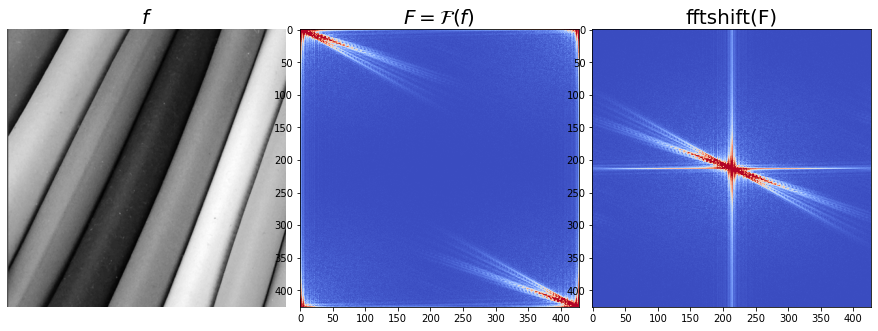

In [594]:
def plot_spectrum(F, cmap='coolwarm'):
    plt.imshow(np.minimum(np.abs(F).astype(int)+100, 255), cmap=cmap)
    
f = imread('images/books.png', True)
h, w = im.shape
F = np.fft.fft2(f)

plt.figure(figsize=(12,5))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.1)
plt.subplot(131), plt.imshow(f), plt.axis('off'), plt.axis('off'), plt.title(r'$f$', size=20)
plt.subplot(132), plot_spectrum(F), plt.title(r'$F=\mathcal{F}(f)$', size=20)
plt.subplot(133), plot_spectrum(np.fft.fftshift(F)), plt.title(r'fftshift(F)', size=20)
plt.show()

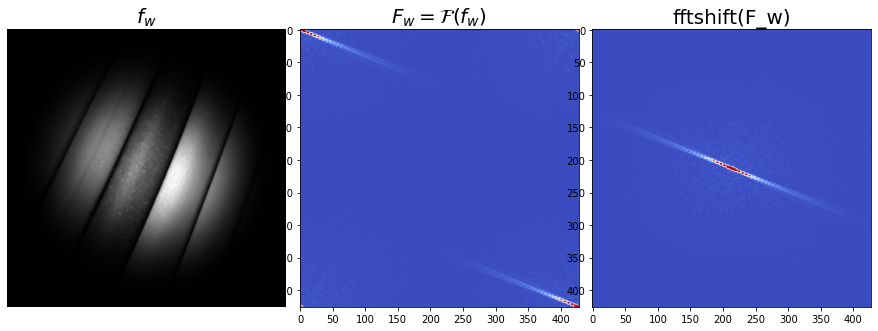

In [568]:
f_windowed = f * window(('parzen'), f.shape) # f * window(('gaussian', 50), im.shape)
F_windowed = np.fft.fft2(f_windowed)

plt.figure(figsize=(12,5))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.1)
plt.subplot(131), plt.imshow(f_windowed), plt.axis('off'), plt.title(r'$f_w$', size=20)
plt.subplot(132), plot_spectrum(F_windowed), plt.title(r'$F_w=\mathcal{F}(f_w)$', size=20)
plt.subplot(133), plot_spectrum(np.fft.fftshift(F_windowed)), plt.title('fftshift(F_w)', size=20)
plt.show()

### Ringing Artifact

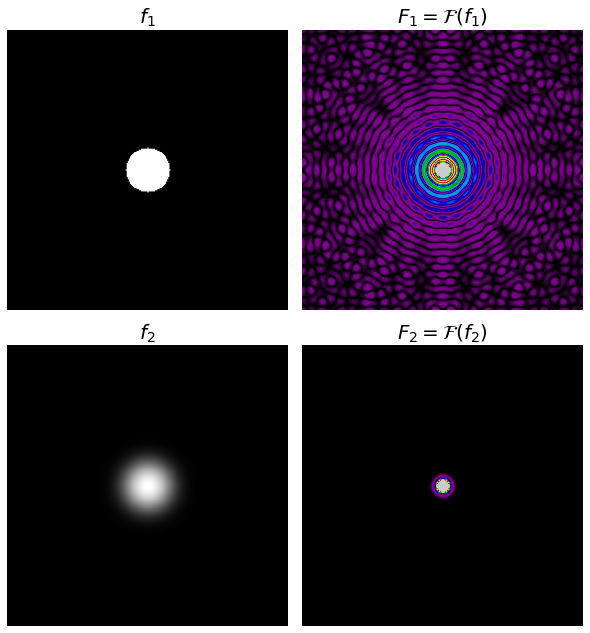

In [287]:
n = 256
f = np.zeros((n,n))
c = 20
x, y = np.meshgrid(np.arange(n), np.arange(n))
f[(x-n/2)**2+(y-n/2)**2<=c**2] = 1
F = np.fft.fft2(f)
f1 = f.copy()
f1 = gaussian(f1, 10)
F1 = np.fft.fft2(f1)
plt.figure(figsize=(8,9))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
plt.subplot(221), plt.imshow(f), plt.axis('off'), plt.axis('off'), plt.title(r'$f_1$', size=20)
plt.subplot(222), plot_spectrum(np.fft.fftshift(F), cmap='nipy_spectral'), plt.axis('off'), plt.title(r'$F_1=\mathcal{F}(f_1)$', size=20)
plt.subplot(223), plt.imshow(f1), plt.axis('off'), plt.title(r'$f_2$', size=20)
plt.subplot(224), plot_spectrum(np.fft.fftshift(F1), cmap='nipy_spectral'), plt.axis('off'), plt.title(r'$F_2=\mathcal{F}(f_2)$', size=20)
plt.show()

### 3. Linearity / Distributivity

In [ ]:
f1, f2 = imread('images/cat1.png', True), imread('images/cat2.png', True) 
F1, F2 = np.fft.fft2(f1), np.fft.fft2(f2)
F = F1 + F2
f_hat = np.fft.ifft2(F)
plt.figure(figsize=(15,7))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.1)
plt.subplot(231), plt.imshow(f1), plt.axis('off'), plt.axis('off'), plt.title(r'$f_1$', size=20)
plt.subplot(232), plt.imshow(np.minimum(np.abs(np.fft.fftshift(F1)).astype(int)+100, 255), cmap='coolwarm'), plt.title(r'$F_1=\mathcal{F}(f_1)$', size=20)
plt.subplot(234), plt.imshow(f2), plt.axis('off'), plt.title(r'$f_2$', size=20)
plt.subplot(235), plt.imshow(np.minimum(np.abs(np.fft.fftshift(F2)).astype(int)+100, 255), cmap='coolwarm'), plt.title(r'$F_2=\mathcal{F}(f_2)$', size=20)
plt.subplot(233), plt.imshow(np.minimum(np.abs(np.fft.fftshift(F)).astype(int)+100, 255), cmap='coolwarm'), plt.title(r'$F=F_1+F_2$', size=20)
plt.subplot(236), plt.imshow(f_hat.real), plt.axis('off'), plt.title(r'$\mathcal{F}^{-1}(F)$', size=20)
plt.show()

### 4. Rotation

Rotating the input image by an angle $\theta$ implies rotating the spectrum by the same angle $\theta$, as shown in the figure below. 

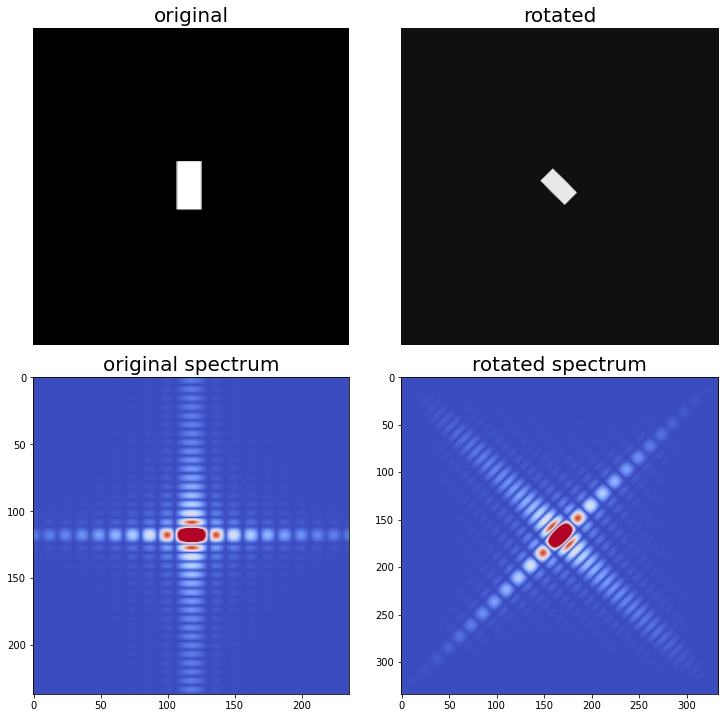

In [18]:
from scipy.ndimage import rotate

im = imread('images/box.png', True)
F = np.fft.fftshift(np.fft.fft2(im))
im_rot = rotate(im, 45)
F_rot = np.fft.fftshift(np.fft.fft2(im_rot))
plt.figure(figsize=(10,10))
plt.gray()
plt.subplots_adjust(0,0,1,0.925,0.05,0.1)
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('original', size=20)
plt.subplot(222), plt.imshow(im_rot), plt.axis('off'), plt.title('rotated', size=20)
plt.subplot(223), plot_spectrum(F), plt.title('original spectrum', size=20)
plt.subplot(224), plot_spectrum(F_rot), plt.title('rotated spectrum', size=20)
plt.show()

### 5. Similarity / Scaling

In [ ]:
f_small = imread('images/box.png', True)
F_small = np.fft.fftshift(np.fft.fft2(f_small))
f_large = imread('images/box_streched.png', True)
F_large = np.fft.fftshift(np.fft.fft2(f_large))
plt.figure(figsize=(10,10))
plt.gray()
plt.subplots_adjust(0,0,1,0.925,0.05,0.1)
plt.subplot(221), plt.imshow(f_small), plt.axis('off'), plt.title('small', size=20)
plt.subplot(222), plt.imshow(f_large), plt.axis('off'), plt.title('streched', size=20)
plt.subplot(223), plot_spectrum(F_small), plt.title('small spectrum', size=20)
plt.subplot(224), plot_spectrum(F_large), plt.title('streched spectrum', size=20)
plt.show()

### 6. Translation and Shift in Phase

In [ ]:
im_shift = imread('images/box_shifted.png', True)

F = np.fft.fftshift(np.fft.fft2(im))
F_shift = np.fft.fftshift(np.fft.fft2(im_shift))

plt.figure(figsize=(15,10))
plt.gray()
plt.subplots_adjust(0,0,1,0.925,0.05,0.12)
plt.subplot(231), plt.imshow(im), plt.axis('off'), plt.title('original', size=20)
plt.subplot(232), plot_spectrum(F), plt.title('original spectrum', size=20)
plt.subplot(233), plt.imshow(np.arctan(F.imag/F.real), cmap='inferno'), plt.title('original phase', size=20)
plt.subplot(234), plt.imshow(im_shift), plt.axis('off'), plt.title('shifted', size=20)
plt.subplot(235), plot_spectrum(F_shift), plt.title('shifted spectrum', size=20)
plt.subplot(236), plt.imshow(np.arctan(F_shift.imag/F_shift.real), cmap='inferno'), plt.title('shifted phase', size=20)
plt.show()

### 7. Conservation of Energy: Parseval / Raleigh Theorem

Parseval / Rayleigh’s theorem states of the conservation of **energy** between the spatial and the frequency domains and stated as follows for a 2-D signal (image) $f$ of size $M \times N$:

$$\sum\limits_{x=0}^{M-1}\sum_{y=0}^{N-1}|f(x,y)|^2 = \frac{1}{MN}\sum\limits_{u=0}^{M-1}\sum_{v=0}^{N-1}|F(u,v)|^2$$

The next code snippet demonstrates that the above theorem holds true for the input *lena* image.

In [135]:
f = imread('images/lena.jpg', True)
print(f.shape)
F = np.fft.fft2(f)
f_energy, F_energy = np.sum(np.abs(F)**2) / np.prod(f.shape), np.sum(f**2)
f_energy, F_energy, np.isclose(f_energy, F_energy)

(220, 220)


(11918.093481563103, 11918.0934815631, True)

## Understanding Convolution

In [ ]:
im = rgb2gray(imread('images/cameraman.jpg')).astype(float)
print(np.max(im))
print(im.shape)
blur_box_kernel = np.ones((3,3)) / 9
edge_laplace_kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
im_blurred = signal.convolve2d(im, blur_box_kernel)
im_edges = np.clip(signal.convolve2d(im, edge_laplace_kernel), 0, 1)
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(18,6))
axes[0].imshow(im, cmap=plt.cm.gray)
axes[0].set_title('Original Image', size=20)
axes[1].imshow(im_blurred, cmap=plt.cm.gray)
axes[1].set_title('Box Blur', size=20)
axes[2].imshow(im_edges, cmap=plt.cm.gray)
axes[2].set_title('Laplace Edge Detection', size=20)
for ax in axes:
    ax.axis('off')
plt.show()

### Applying convolution to a color (RGB) image

With `scipy.signal`'s `convolve2d()`, we can **sharpen** an RGB image as well. We have to apply the
convolution separately for each image channel. Let's use the *tajmahal* image, with the **emboss** kernel and the **schar edge detection** complex kernel, using the next code snippet. You'll get your original image along with the convolved images with a couple of different kernels, as shown in the next figure.

1.0
(340, 527, 3)


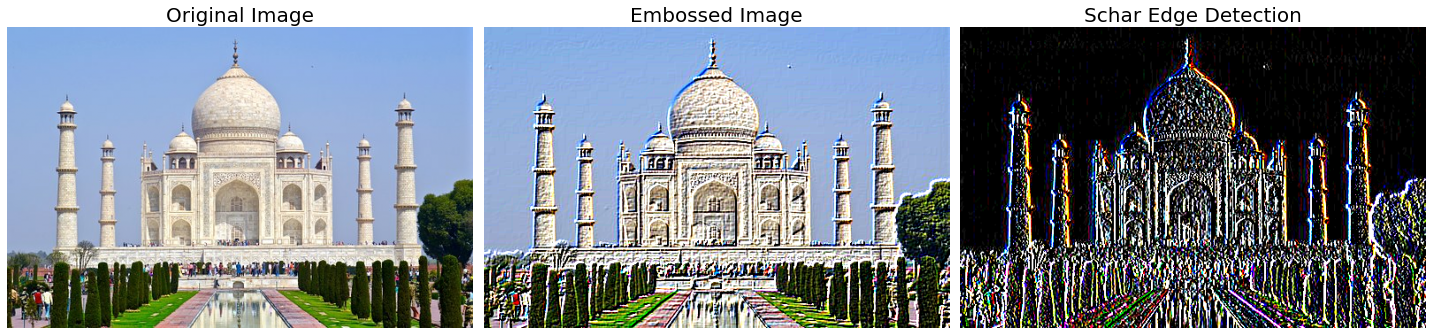

In [461]:
im = imread('images/tajmahal.jpg')
im = im / im.max() # scale each pixel value in [0,1]
print(np.max(im))
print(im.shape)
emboss_kernel = np.array([[-2,-1,0],[-1,1,1],[0,1,2]])
edge_schar_kernel = np.array([[ -3-3j, 0-10j, +3 -3j], [-10+0j, 0+ 0j, +10+0j], [ -3+3j, 0+10j, +3 +3j]])
im_embossed = np.ones(im.shape)
im_edges = np.ones(im.shape)
for i in range(3):
    im_embossed[...,i] = np.clip(signal.convolve2d(im[...,i], emboss_kernel, mode='same', boundary="symm"),0,1)
for i in range(3):
    im_edges[:,:,i] = np.clip(np.real(signal.convolve2d(im[...,i], edge_schar_kernel, mode='same', boundary="symm")),0,1)
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))
axes[0].imshow(im)
axes[0].set_title('Original Image', size=20)
axes[1].imshow(im_embossed)
axes[1].set_title('Embossed Image', size=20)
axes[2].imshow(im_edges)
axes[2].set_title('Schar Edge Detection', size=20)
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Convolution with scipy.ndimage

With `scipy.ndimage.convolve()`, we can sharpen an RGB image directly (we do not
have to apply the convolution separately for each image channel).
Use the *victoria_memorial* image with $3 \times 3$ **sharpen**, **emboss** and **lighten** kernels defined in the next code snippet:

In [ ]:
im = imread('images/victoria_memorial.png') # read as float
im = im / im.max()
sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]).reshape((3, 3, 1))
emboss_kernel = np.array([[-2,-1,0],[-1,1,1],[0,1,2]]).reshape((3, 3, 1))
lighten_kernel = (np.array([[0,0,0], [0,12,0], [0,0,0]])/9).reshape((3, 3, 1))

im_sharp = np.clip(ndimage.convolve(im, sharpen_kernel, mode='nearest'), 0, 1) # clip (0 to 255) and convert to unsigned int
im_emboss = np.clip(ndimage.convolve(im, emboss_kernel, mode='nearest'), 0, 1)
im_draw = np.clip(ndimage.convolve(im, draw_kernel, mode='nearest'), 0, 1)
plt.figure(figsize=(15,12))
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('Original Image', size=25)
plt.subplot(222), plt.imshow(im_sharp), plt.axis('off'), plt.title('Sharpened Image', size=25)
plt.subplot(223), plt.imshow(im_emboss), plt.axis('off'), plt.title('Embossed Image', size=25)
plt.subplot(224), plt.imshow(im_draw), plt.axis('off'), plt.title('Lightened Image', size=25)
plt.tight_layout()
plt.show()

### Template matching with cross-correlation between the image and template

In this example, we'll use cross-correlation with the eye template image (using template image as kernel for cross-correlation with the original racoon face image), to find the location of the eye in the raccoon face image. Let's mark the location with the largest cross-correlation value (the best match with the template) with a red dot.  

In [ ]:
face_image = misc.face(gray=True) - misc.face(gray=True).mean()
template_image = np.copy(face_image[300:365, 670:750]) # right eye
template_image -= template_image.mean()
face_image = face_image + np.random.randn(*face_image.shape) * 50 # add random noise
correlation = signal.correlate2d(face_image, template_image, boundary='symm', mode='same')
y, x = np.unravel_index(np.argmax(correlation), correlation.shape) # find the match

fig, (ax_original, ax_template, ax_correlation) = plt.subplots(1, 3, figsize=(15, 5))
ax_original.imshow(face_image, cmap='gray', aspect='auto')
ax_original.set_title('Original', size=20)
ax_original.set_axis_off()
ax_template.imshow(template_image, cmap='gray', aspect='auto')
ax_template.set_title('Template', size=20)
ax_template.set_axis_off()
ax_correlation.imshow(correlation, cmap='afmhot', aspect='auto')
ax_correlation.set_title('Cross-correlation', size=20)
ax_correlation.set_axis_off()
ax_original.plot(x, y, 'ro')
plt.tight_layout()
fig.show()